In [1]:
import rasterio as rio
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import rasterio
import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress

import warnings
warnings.filterwarnings('ignore')

In [2]:
run ../util/setupConsole_su

In [3]:
cmip6_models = ['bcc-csm2-mr', 'bcc-esm1', 'canesm5', \
                'kace-1-0-g', 'ipsl-cm6a-lr', 'miroc6', \
                'mri-esm2-0', 'noresm2-lm']

cmip6_lat = np.arange(-90, 90, 1.5)
cmip6_lon = np.arange(0, 360, 1.5)


In [4]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirEra5Land = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5-Land'
dirCMIP6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'

In [5]:
# huss_era5 = xr.open_mfdataset('%s/daily/huss_*.nc'%dirEra5)
# huss_era5 = huss_era5.sel(time=slice('1981', '2021'))
# huss_era5_mean = huss_era5.mean(dim='time')
# # tn_era5_mean.compute()
# huss_era5_mean.to_netcdf('era5_huss_mean.nc')

In [6]:
era5_max_deciles = xr.open_dataset('%s/era5_tw_max_deciles.nc'%dirHeatData)
lat = era5_max_deciles.latitude.values
lon = era5_max_deciles.longitude.values

In [7]:
land_sea_mask = xr.open_dataset('%s/land-sea-mask.nc'%dirEra5)
land_sea_mask.load()
land_sea_mask = land_sea_mask.lsm.mean(dim='time')
land_sea_mask_binary = land_sea_mask > 0.1


In [8]:

from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
tx_tw_corr_mean = xr.open_mfdataset('output/tx_tw_corr/tx_tw_corr_warm_season_*.nc', preprocess = add_time_dim, concat_dim='time')
tx_tw_corr_mean['time'] = time_dim
tx_tw_corr_mean = tx_tw_corr_mean.rename({'__xarray_dataarray_variable__':'tx_tw_corr'})
tx_tw_corr_mean = tx_tw_corr_mean.mean(dim='time')
tx_tw_corr_mean.load()

<xarray.Dataset>
Dimensions:     (latitude: 721, longitude: 1440)
Coordinates:
  * longitude   (longitude) float32 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude    (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    year        int64 2021
Data variables:
    tx_tw_corr  (latitude, longitude) float64 0.9793 0.9793 ... 0.9993 0.9993

In [9]:
tw_era5_mean = xr.open_dataset('era5_tw_max_mean.nc')
tw_era5_mean.load()
tw_era5_mean['tw'] = tw_era5_mean['tw'].where(land_sea_mask_binary, np.nan)
tw_era5_mean['tw'] = tw_era5_mean['tw'].sel(latitude=slice(60,-60))

tx_era5_mean = xr.open_dataset('era5_tasmax_mean.nc')
tx_era5_mean.load()
tx_era5_mean['mx2t'] -= 273.15

huss_era5_mean = xr.open_dataset('era5_huss_mean.nc')
huss_era5_mean.load()

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables:
    q          (latitude, longitude) float64 0.06711 0.06711 ... 0.005539

In [11]:
tx_tw_corr_trend = xr.open_dataset('era5_tx_tw_corr_warm_season_trend.nc')
tx_tw_corr_trend.load()
tx_tw_corr_trend['tx_tw_corr_warm_season_trend'] = tx_tw_corr_trend['tx_tw_corr_warm_season_trend'].sel(latitude=slice(60,-60))
tx_tw_corr_trend['tx_tw_corr_warm_season_p_value'] = tx_tw_corr_trend['tx_tw_corr_warm_season_p_value'].sel(latitude=slice(60,-60))

tx_huss_corr_trend = xr.open_dataset('era5_tx_huss_corr_warm_season_trends.nc')
tx_huss_corr_trend.load()
tx_huss_corr_trend['tx_huss_corr_warm_season_trend'] = tx_huss_corr_trend['tx_huss_corr_warm_season_trend'].sel(latitude=slice(60,-60))
tx_huss_corr_trend['tx_huss_corr_warm_season_p_value'] = tx_huss_corr_trend['tx_huss_corr_warm_season_p_value'].sel(latitude=slice(60,-60))


In [11]:
tp_on_tx_trend = xr.open_dataset('era5_tp_on_tx_warm_season_trend.nc')
tp_on_tx_trend.load()
tp_on_tx_trend['tp_on_tx_warm_season_trend'] = tp_on_tx_trend['tp_on_tx_warm_season_trend'].sel(latitude=slice(60,-60))
tp_on_tx_trend['tp_on_tx_warm_season_p_value'] = tp_on_tx_trend['tp_on_tx_warm_season_p_value'].sel(latitude=slice(60,-60))


tp_on_tw_trend = xr.open_dataset('era5_tp_on_tw_warm_season_trend.nc')
tp_on_tw_trend.load()
tp_on_tw_trend['tp_on_tw_warm_season_trend'] = tp_on_tw_trend['tp_on_tw_warm_season_trend'].sel(latitude=slice(60,-60))
tp_on_tw_trend['tp_on_tw_warm_season_p_value'] = tp_on_tw_trend['tp_on_tw_warm_season_p_value'].sel(latitude=slice(60,-60))




In [12]:
ef_on_tx_trend = xr.open_dataset('era5_ef_on_warm_season_tx_trends_by_decile.nc')
ef_on_tx_trend = ef_on_tx_trend.rename({'ef_on_tx_warm_season_trend':'ef_on_warm_season_tx_trend',
                                       'ef_on_tx_warm_season_p_value':'ef_on_warm_season_tx_p_value'})
ef_on_tx_trend.load()
ef_on_tx_trend['ef_on_warm_season_tx_trend'] = ef_on_tx_trend['ef_on_warm_season_tx_trend'].sel(latitude=slice(60,-60))
ef_on_tx_trend['ef_on_warm_season_tx_p_value'] = ef_on_tx_trend['ef_on_warm_season_tx_p_value'].sel(latitude=slice(60,-60))


In [13]:
huss_on_tx_trend = xr.open_dataset('era5_huss_on_warm_season_tx_trends_by_decile_new.nc')
huss_on_tx_trend.load()
huss_on_tx_trend['huss_on_warm_season_tx_trend'] = huss_on_tx_trend['huss_on_warm_season_tx_trend'].sel(latitude=slice(60,-60))
huss_on_tx_trend['huss_on_warm_season_tx_p_value'] = huss_on_tx_trend['huss_on_warm_season_tx_p_value'].sel(latitude=slice(60,-60))

huss_on_tw_trend = xr.open_dataset('era5_huss_on_warm_season_tw_trends_by_decile_new.nc')
huss_on_tw_trend.load()
huss_on_tw_trend['huss_on_warm_season_tw_trend'] = huss_on_tw_trend['huss_on_warm_season_tw_trend'].sel(latitude=slice(60,-60))
huss_on_tw_trend['huss_on_warm_season_tw_p_value'] = huss_on_tw_trend['huss_on_warm_season_tw_p_value'].sel(latitude=slice(60,-60))


In [14]:
evap_on_tw_trend = xr.open_dataset('era5_evaporation_on_warm_season_tw_trends_by_decile_new.nc')
evap_on_tw_trend.load()
evap_on_tw_trend['evaporation_on_warm_season_tw_trend'] *= -1
evap_on_tw_trend['evaporation_on_warm_season_tw_trend'] = evap_on_tw_trend['evaporation_on_warm_season_tw_trend'].sel(latitude=slice(60,-60))
evap_on_tw_trend['evaporation_on_warm_season_tw_p_value'] = evap_on_tw_trend['evaporation_on_warm_season_tw_p_value'].sel(latitude=slice(60,-60))

evap_on_tx_trend = xr.open_dataset('era5_evaporation_on_warm_season_tx_trends_by_decile_new.nc')
evap_on_tx_trend.load()
evap_on_tx_trend['evaporation_on_warm_season_tx_trend'] *= -1
evap_on_tx_trend['evaporation_on_warm_season_tx_trend'] = evap_on_tx_trend['evaporation_on_warm_season_tx_trend'].sel(latitude=slice(60,-60))
evap_on_tx_trend['evaporation_on_warm_season_tx_p_value'] = evap_on_tx_trend['evaporation_on_warm_season_tx_p_value'].sel(latitude=slice(60,-60))


In [15]:
tw = xr.open_dataset('era5_tw_warm_season_trends_by_decile_new.nc')
tw.load()
tw['tw_on_warm_season_trend'] = tw['tw_on_warm_season_trend'].sel(latitude=slice(60,-60))
tw['tw_on_warm_season_p_value'] = tw['tw_on_warm_season_p_value'].sel(latitude=slice(60,-60))

tx = xr.open_dataset('era5_tx_warm_season_trends_by_decile_new.nc')
tx.load()
tx['tx_on_warm_season_trend'] = tx['tx_on_warm_season_trend'].sel(latitude=slice(60,-60))
tx['tx_on_warm_season_p_value'] = tx['tx_on_warm_season_p_value'].sel(latitude=slice(60,-60))

In [16]:
tw_on_tx_trend = xr.open_dataset('era5_tw_on_warm_season_tx_trends_by_decile_new.nc')
tw_on_tx_trend.load()
tw_on_tx_trend['tw_on_warm_season_tx_trend'] = tw_on_tx_trend['tw_on_warm_season_tx_trend'].sel(latitude=slice(60,-60))
tw_on_tx_trend['tw_on_warm_season_tx_p_value'] = tw_on_tx_trend['tw_on_warm_season_tx_p_value'].sel(latitude=slice(60,-60))

tx_on_tw_trend = xr.open_dataset('era5_tx_on_warm_season_tw_trends_by_decile_new.nc')
tx_on_tw_trend.load()
tx_on_tw_trend['tx_on_warm_season_tw_trend'] = tx_on_tw_trend['tx_on_warm_season_tw_trend'].sel(latitude=slice(60,-60))
tx_on_tw_trend['tx_on_warm_season_tw_p_value'] = tx_on_tw_trend['tx_on_warm_season_tw_p_value'].sel(latitude=slice(60,-60))

In [17]:
sm_on_tx_trends = xr.open_dataset('era5_sm_on_warm_season_tx_trends_by_decile_new.nc')
sm_on_tx_trends.load()
sm_on_tx_trends['sm_on_warm_season_tx_trend'] = sm_on_tx_trends['sm_on_warm_season_tx_trend'].sel(latitude=slice(60,-60))
sm_on_tx_trends['sm_on_warm_season_tx_p_value'] = sm_on_tx_trends['sm_on_warm_season_tx_p_value'].sel(latitude=slice(60,-60))

sm_on_tw_trends = xr.open_dataset('era5_sm_on_warm_season_tw_trends_by_decile_new.nc')
sm_on_tw_trends.load()
sm_on_tw_trends['sm_on_warm_season_tw_trend'] = sm_on_tw_trends['sm_on_warm_season_tw_trend'].sel(latitude=slice(60,-60))
sm_on_tw_trends['sm_on_warm_season_tw_p_value'] = sm_on_tw_trends['sm_on_warm_season_tw_p_value'].sel(latitude=slice(60,-60))

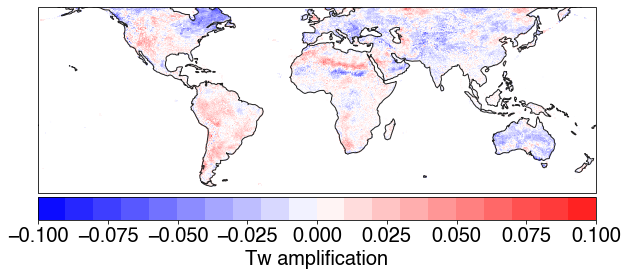

In [18]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.1
v2 = .11
vstep = .01
vlabelstep = .025

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = tw['tw_on_warm_season_trend'][-1,:,:]-tw['tw_on_warm_season_trend'][-11,:,:]

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tw amplification', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

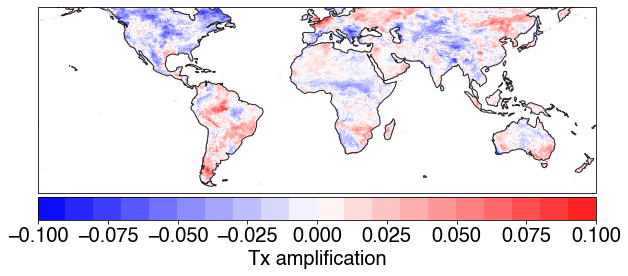

In [19]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.1
v2 = .11
vstep = .01
vlabelstep = .025

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = tx['tx_on_warm_season_trend'][-1,:,:]-tx['tx_on_warm_season_trend'][-11,:,:]

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tx amplification', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

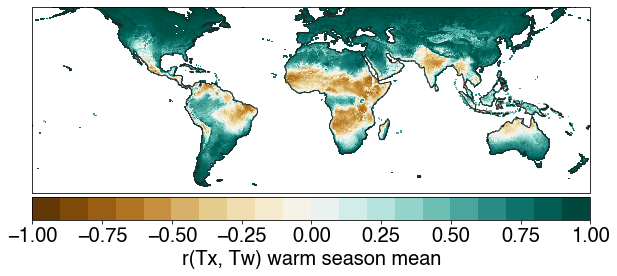

In [20]:


plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = tx_tw_corr_mean.tx_tw_corr

masked_data = data.where(land_sea_mask_binary)

c = plt.pcolormesh(lon, lat, masked_data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw) warm season mean', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)



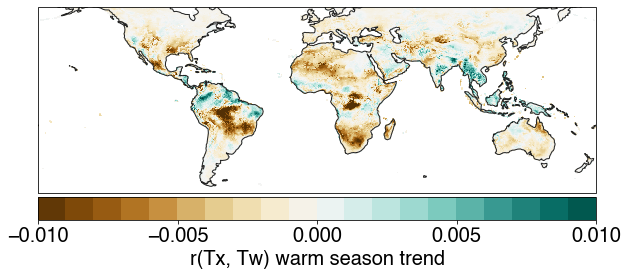

In [21]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.01
v2 = .011
vstep = .001
vlabelstep = .005

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = tx_tw_corr_trend.tx_tw_corr_warm_season_trend
p_val = tx_tw_corr_trend.tx_tw_corr_warm_season_p_value

mask = p_val < 0.1
masked_data = data.where(mask)

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw) warm season trend', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)



In [ ]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.01
v2 = .011
vstep = .001
vlabelstep = .005

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = tx_huss_corr_trend.tx_huss_corr_warm_season_trend
# p_val = tx_huss_corr_trend.tx_tw_corr_warm_season_p_value

# mask = p_val < 0.1
# masked_data = data.where(mask)

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Huss) warm season trend', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)



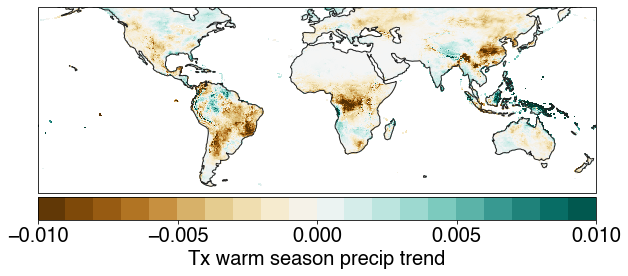

In [22]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.01
v2 = .011
vstep = .001
vlabelstep = .005

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = tp_on_tx_trend.tp_on_tx_warm_season_trend

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tx warm season precip trend', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)



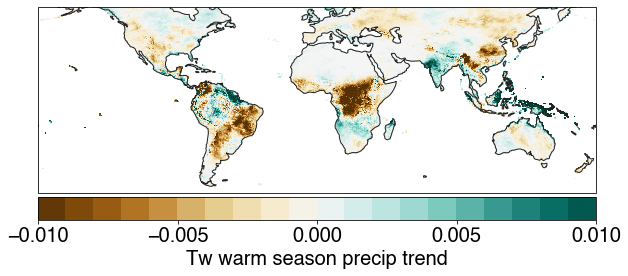

In [23]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.01
v2 = .011
vstep = .001
vlabelstep = .005

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = tp_on_tw_trend.tp_on_tw_warm_season_trend

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tw warm season precip trend', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)



In [ ]:
v1 = tx_tw_corr_1d
v2 = evap_on_tx_50_1d

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.02
x2 = .015

plt.scatter(v1, v2)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='r^2 = %.2f'%mdl.rsquared)
plt.xlabel('r(Tx, Tw) trend')
plt.ylabel('100th pct Tx trend')
plt.legend()

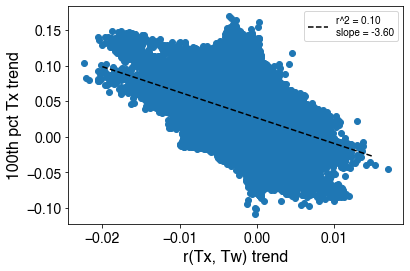

In [47]:
v1 = tx_tw_corr_1d
v2 = tx_100_1d

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.02
x2 = .015

plt.scatter(v1, v2)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='r^2 = %.2f\nslope = %.2f'%(mdl.rsquared, mdl.params[1]))
plt.xlabel('r(Tx, Tw) trend')
plt.ylabel('100th pct Tx trend')
plt.legend()

Text(0, 0.5, 'Tw on Tx trend')

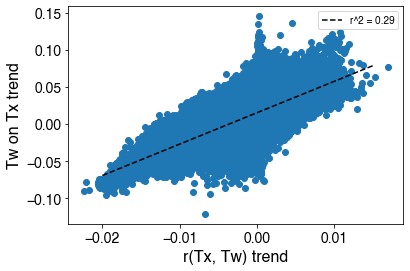

In [162]:
v1 = tx_tw_corr_1d
v2 = tw_on_tx_100_1d

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.02
x2 = .015

plt.scatter(v1, v2)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='r^2 = %.2f'%mdl.rsquared)
plt.legend()
plt.xlabel('r(Tx, Tw) trend')
plt.ylabel('Tw on Tx trend')

Text(0, 0.5, 'Tx amplification')

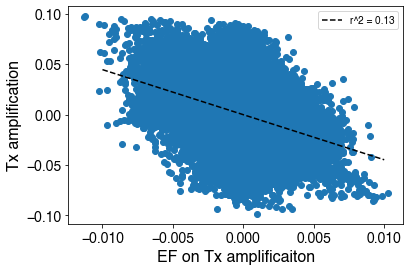

In [36]:

v1 = ef_on_tx_amp_1d
v2 = tx_amp_1d

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.01
x2 = .01

plt.scatter(v1, v2)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='r^2 = %.2f'%mdl.rsquared)
plt.legend()
plt.xlabel('EF on Tx amplificaiton')
plt.ylabel('Tx amplification')



In [24]:
p1 = -1
p2 = -11
p3 = 0

tw_100_1d = tw.tw_on_warm_season_trend[p1,:,:].values.reshape(tw.tw_on_warm_season_trend[p1,:,:].size)
tw_100_p_1d = tw.tw_on_warm_season_p_value[p1,:,:].values.reshape(tw.tw_on_warm_season_p_value[p1,:,:].size)
tw_50_1d = tw.tw_on_warm_season_trend[p2,:,:].values.reshape(tw.tw_on_warm_season_trend[p2,:,:].size)
tw_50_p_1d = tw.tw_on_warm_season_p_value[p1,:,:].values.reshape(tw.tw_on_warm_season_p_value[p2,:,:].size)

tw_amp = tw.tw_on_warm_season_trend[p1,:,:]-tw.tw_on_warm_season_trend[p2,:,:]
tw_mean_1d = tw_era5_mean.tw.values.reshape(tw_era5_mean.tw.values.size)
tw_amp_1d = tw_amp.values.reshape(tw_amp.values.size)

tx_100_1d = tx.tx_on_warm_season_trend[p1,:,:].values.reshape(tx.tx_on_warm_season_trend[p1,:,:].size)
tx_100_1d = tx.tx_on_warm_season_trend[-2,:,:].values.reshape(tx.tx_on_warm_season_trend[-2,:,:].size)
tx_50_1d = tx.tx_on_warm_season_trend[p2,:,:].values.reshape(tx.tx_on_warm_season_trend[p2,:,:].size)
tx_amp = tx.tx_on_warm_season_trend[p1,:,:]-tx.tx_on_warm_season_trend[p2,:,:]
tx_mean_1d = tx_era5_mean.mx2t.values.reshape(tx_era5_mean.mx2t.values.size)
tx_amp_1d = tx_amp.values.reshape(tx_amp.values.size)

huss_mean_1d = huss_era5_mean.q.values.reshape(huss_era5_mean.q.values.size)

sm_on_tx_100_1d = sm_on_tx_trends.sm_on_warm_season_tx_trend[-1,:,:].values.reshape(sm_on_tx_trends.sm_on_warm_season_tx_trend[-1,:,:].size)
sm_on_tx_50_1d = sm_on_tx_trends.sm_on_warm_season_tx_trend[-10,:,:].values.reshape(sm_on_tx_trends.sm_on_warm_season_tx_trend[-10,:,:].size)
sm_on_tx_amp = sm_on_tx_trends.sm_on_warm_season_tx_trend[-1,:,:]-sm_on_tx_trends.sm_on_warm_season_tx_trend[-10,:,:]
sm_on_tx_amp_1d = sm_on_tx_amp.values.reshape(sm_on_tx_amp.values.size)

huss_on_tx_100_1d = huss_on_tx_trend.huss_on_warm_season_tx_trend[-1,:,:].values.reshape(huss_on_tx_trend.huss_on_warm_season_tx_trend[-1,:,:].size)
huss_on_tx_50_1d = huss_on_tx_trend.huss_on_warm_season_tx_trend[-10,:,:].values.reshape(huss_on_tx_trend.huss_on_warm_season_tx_trend[-10,:,:].size)
huss_on_tx_amp = huss_on_tx_trend.huss_on_warm_season_tx_trend[-1,:,:]-huss_on_tx_trend.huss_on_warm_season_tx_trend[-10,:,:]
huss_on_tx_amp_1d = huss_on_tx_amp.values.reshape(huss_on_tx_amp.values.size)

evap_on_tx_100_1d = evap_on_tx_trend.evaporation_on_warm_season_tx_trend[-1,:,:].values.reshape(evap_on_tx_trend.evaporation_on_warm_season_tx_trend[-1,:,:].size)
evap_on_tx_50_1d = evap_on_tx_trend.evaporation_on_warm_season_tx_trend[-10,:,:].values.reshape(evap_on_tx_trend.evaporation_on_warm_season_tx_trend[-10,:,:].size)
evap_on_tx_amp = evap_on_tx_trend.evaporation_on_warm_season_tx_trend[-1,:,:]-evap_on_tx_trend.evaporation_on_warm_season_tx_trend[-10,:,:]
evap_on_tx_amp_1d = evap_on_tx_amp.values.reshape(evap_on_tx_amp.values.size)

ef_on_tx_100_1d = ef_on_tx_trend.ef_on_warm_season_tx_trend[-1,:,:].values.reshape(ef_on_tx_trend.ef_on_warm_season_tx_trend[-1,:,:].size)
ef_on_tx_50_1d = ef_on_tx_trend.ef_on_warm_season_tx_trend[-10,:,:].values.reshape(ef_on_tx_trend.ef_on_warm_season_tx_trend[-10,:,:].size)
ef_on_tx_amp = ef_on_tx_trend.ef_on_warm_season_tx_trend[-1,:,:]-ef_on_tx_trend.ef_on_warm_season_tx_trend[-10,:,:]
ef_on_tx_amp_1d = ef_on_tx_amp.values.reshape(ef_on_tx_amp.values.size)



tw_on_tx_100_1d = tw_on_tx_trend.tw_on_warm_season_tx_trend[-1,:,:].values.reshape(tw_on_tx_trend.tw_on_warm_season_tx_trend[-1,:,:].size)
tw_on_tx_50_1d = tw_on_tx_trend.tw_on_warm_season_tx_trend[-10,:,:].values.reshape(tw_on_tx_trend.tw_on_warm_season_tx_trend[-10,:,:].size)
tw_on_tx_amp = tw_on_tx_trend.tw_on_warm_season_tx_trend[-1,:,:]-tw_on_tx_trend.tw_on_warm_season_tx_trend[-10,:,:]
tw_on_tx_amp_1d = tw_on_tx_amp.values.reshape(tw_on_tx_amp.values.size)

tp_on_tx_1d = tp_on_tx_trend.tp_on_tx_warm_season_trend.values.reshape([tp_on_tx_trend.tp_on_tx_warm_season_trend.values.size])
tp_on_tw_1d = tp_on_tw_trend.tp_on_tw_warm_season_trend.values.reshape([tp_on_tw_trend.tp_on_tw_warm_season_trend.values.size])

tx_tw_corr_1d = tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.reshape([tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.size])
tx_tw_corr_mean_1d = tx_tw_corr_mean.tx_tw_corr.values.reshape([tx_tw_corr_mean.tx_tw_corr.values.size])


huss_on_tw_100_1d = huss_on_tw_trend.huss_on_warm_season_tw_trend[-1,:,:].values.reshape(huss_on_tw_trend.huss_on_warm_season_tw_trend[-1,:,:].size)
huss_on_tw_50_1d = huss_on_tw_trend.huss_on_warm_season_tw_trend[-10,:,:].values.reshape(huss_on_tw_trend.huss_on_warm_season_tw_trend[-10,:,:].size)
huss_on_tw_amp = huss_on_tw_trend.huss_on_warm_season_tw_trend[-1,:,:]-huss_on_tw_trend.huss_on_warm_season_tw_trend[-10,:,:]
huss_on_tw_amp_1d = huss_on_tw_amp.values.reshape(huss_on_tw_amp.values.size)

evap_on_tw_100_1d = evap_on_tw_trend.evaporation_on_warm_season_tw_trend[-1,:,:].values.reshape(evap_on_tw_trend.evaporation_on_warm_season_tw_trend[-1,:,:].size)
evap_on_tw_50_1d = evap_on_tw_trend.evaporation_on_warm_season_tw_trend[-10,:,:].values.reshape(evap_on_tw_trend.evaporation_on_warm_season_tw_trend[-10,:,:].size)
evap_on_tw_amp = evap_on_tw_trend.evaporation_on_warm_season_tw_trend[-1,:,:]-evap_on_tw_trend.evaporation_on_warm_season_tw_trend[-10,:,:]
evap_on_tw_amp_1d = evap_on_tw_amp.values.reshape(evap_on_tw_amp.values.size)

sm_on_tw_100_1d = sm_on_tw_trends.sm_on_warm_season_tw_trend[-1,:,:].values.reshape(sm_on_tw_trends.sm_on_warm_season_tw_trend[-1,:,:].size)
sm_on_tw_50_1d = sm_on_tw_trends.sm_on_warm_season_tw_trend[-10,:,:].values.reshape(sm_on_tw_trends.sm_on_warm_season_tw_trend[-10,:,:].size)
sm_on_tw_amp = sm_on_tw_trends.sm_on_warm_season_tw_trend[-1,:,:]-sm_on_tw_trends.sm_on_warm_season_tw_trend[-10,:,:]
sm_on_tw_amp_1d = sm_on_tw_amp.values.reshape(sm_on_tw_amp.values.size)

tx_on_tw_100_1d = tx_on_tw_trend.tx_on_warm_season_tw_trend[-1,:,:].values.reshape(tx_on_tw_trend.tx_on_warm_season_tw_trend[-1,:,:].size)
tx_on_tw_50_1d = tx_on_tw_trend.tx_on_warm_season_tw_trend[-10,:,:].values.reshape(tx_on_tw_trend.tx_on_warm_season_tw_trend[-10,:,:].size)
tx_on_tw_amp = tx_on_tw_trend.tx_on_warm_season_tw_trend[-1,:,:]-tx_on_tw_trend.tx_on_warm_season_tw_trend[-10,:,:]
tx_on_tw_amp_1d = tx_on_tw_amp.values.reshape(tx_on_tw_amp.values.size)

In [63]:
v1 = tx_tw_corr_1d

v2 = huss_on_tx_100_1d

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                 1.145e+05
Date:                Thu, 22 Jun 2023   Prob (F-statistic):               0.00
Time:                        12:40:02   Log-Likelihood:             1.0834e+06
No. Observations:              194483   AIC:                        -2.167e+06
Df Residuals:                  194481   BIC:                        -2.167e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004   2.25e-06    184.962      0.000       0.000       0.000
x1             0.2678      0.001    338.377      0.000       0.266       0.269
==============================================================================
Omnibus:                     5370.777   Durbin-Watson:                   0.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10955.014
Skew:                           0.183   Prob(JB):                         0.00
Kurtosis:                       4.103   Cond. No.                         379.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Tw on Tx amp')

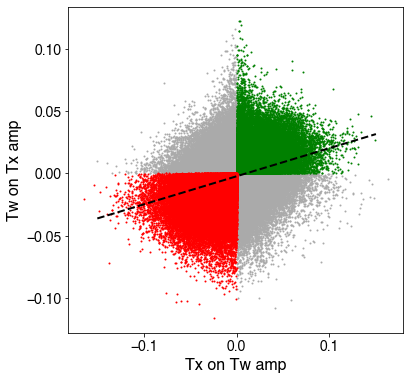

In [15]:
v1 = tx_on_tw_amp_1d
v2 = tw_on_tx_amp_1d

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.15
x2 = .15

plt.figure(figsize=(6,6))
plt.scatter(v1[np.where((v1<0) & (v2>0))[0]], v2[np.where((v1<0) & (v2>0))[0]], c='#aaaaaa', s=1)
plt.scatter(v1[np.where((v1>0) & (v2<0))[0]], v2[np.where((v1>0) & (v2<0))[0]], c='#aaaaaa', s=1)
plt.scatter(v1[np.where((v1>0) & (v2>0))[0]], v2[np.where((v1>0) & (v2>0))[0]], c='g', s=1)
plt.scatter(v1[np.where((v1<0) & (v2<0))[0]], v2[np.where((v1<0) & (v2<0))[0]], c='r', s=1)

plt.plot([x1,x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', lw=2, label='slope=%.2f, r2=%.2f'%(mdl.params[1], mdl.rsquared))
# plt.plot([x1,x2], [x1,x2], '-m')
plt.xlabel('Tx on Tw amp')
plt.ylabel('Tw on Tx amp')

In [16]:
ind_cov = np.where((v1 > 0) & (v2 > 0))[0]
ind_div = np.where((v1 < 0) & (v2 < 0))[0]
ind_tx_no_tw = np.where((v1 > 0) & (v2 < 0))[0]
ind_tw_no_tx = np.where((v1 < 0) & (v2 > 0))[0]
ind_other = np.where( ((v1 > 0) & (v2 < 0)) | ((v1 < 0) & (v2 > 0)))[0]

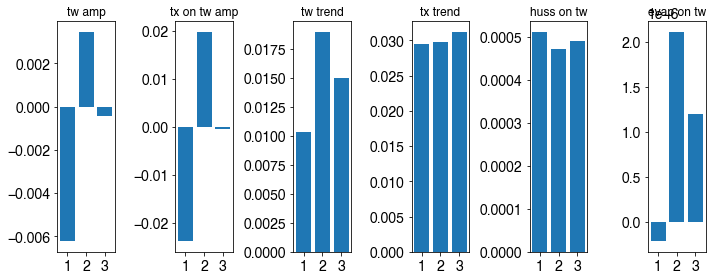

In [17]:
f, ax = plt.subplots(1, 6, figsize=(10,4))
ax[0].bar([1,2, 3], [np.nanmean(tw_amp_1d[ind_div]), np.nanmean(tw_amp_1d[ind_cov]), np.nanmean(tw_amp_1d[ind_other])])
ax[0].set_title('tw amp')
ax[1].bar([1,2, 3], [np.nanmean(tx_on_tw_amp_1d[ind_div]), np.nanmean(tx_on_tw_amp_1d[ind_cov]), np.nanmean(tx_on_tw_amp_1d[ind_other])])
ax[1].set_title('tx on tw amp')

ax[2].bar([1,2, 3], [np.nanmean(tw_100_1d[ind_div]), np.nanmean(tw_100_1d[ind_cov]), np.nanmean(tw_100_1d[ind_other])])
ax[2].set_title('tw trend')

ax[3].bar([1,2, 3], [np.nanmean(tx_100_1d[ind_div]), np.nanmean(tx_100_1d[ind_cov]), np.nanmean(tx_100_1d[ind_other])])
ax[3].set_title('tx trend')


ax[4].bar([1,2, 3], [np.nanmean(huss_on_tw_100_1d[ind_div]), np.nanmean(huss_on_tw_100_1d[ind_cov]), np.nanmean(huss_on_tw_100_1d[ind_other])])
ax[4].set_title('huss on tw')
ax[5].bar([1,2, 3], [np.nanmean(evap_on_tw_100_1d[ind_div]), np.nanmean(evap_on_tw_100_1d[ind_cov]), np.nanmean(evap_on_tw_100_1d[ind_other])])
ax[5].set_title('evap on tw')
plt.tight_layout()

NameError: name 'sm_100_1d' is not defined

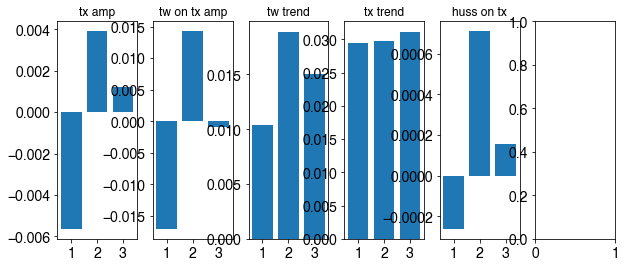

In [18]:
f, ax = plt.subplots(1, 6, figsize=(10,4))
ax[0].bar([1,2, 3], [np.nanmean(tx_amp_1d[ind_div]), np.nanmean(tx_amp_1d[ind_cov]), np.nanmean(tx_amp_1d[ind_other])])
ax[0].set_title('tx amp')
ax[1].bar([1,2, 3], [np.nanmean(tw_on_tx_amp_1d[ind_div]), np.nanmean(tw_on_tx_amp_1d[ind_cov]), np.nanmean(tw_on_tx_amp_1d[ind_other])])
ax[1].set_title('tw on tx amp')

ax[2].bar([1,2, 3], [np.nanmean(tw_100_1d[ind_div]), np.nanmean(tw_100_1d[ind_cov]), np.nanmean(tw_100_1d[ind_other])])
ax[2].set_title('tw trend')

ax[3].bar([1,2, 3], [np.nanmean(tx_100_1d[ind_div]), np.nanmean(tx_100_1d[ind_cov]), np.nanmean(tx_100_1d[ind_other])])
ax[3].set_title('tx trend')


ax[4].bar([1,2, 3], [np.nanmean(huss_on_tx_100_1d[ind_div]), np.nanmean(huss_on_tx_100_1d[ind_cov]), np.nanmean(huss_on_tx_100_1d[ind_other])])
ax[4].set_title('huss on tx')

ax[5].bar([1,2, 3], [np.nanmean(sm_100_1d[ind_div]), np.nanmean(sm_100_1d[ind_cov]), np.nanmean(sm_100_1d[ind_other])])
ax[5].set_title('sm on tx')
plt.tight_layout()

In [19]:
amp1_p = 10

amp2_p = range(11,20,1)
amp2_sm_p = range(11, 20, 1)

tx_amp_by_level = []
tw_amp_by_level = []
huss_on_tw_amp_by_level = []
huss_on_tx_amp_by_level = []
evap_on_tw_amp_by_level = []
evap_on_tx_amp_by_level = []
sm_on_tx_amp_by_level = []
sm_on_tw_amp_by_level = []

tx_sm_slope_by_level = []
tx_sm_r2_by_level = []
tx_huss_slope_by_level = []
tx_huss_r2_by_level = []
tx_evap_slope_by_level = []
tx_evap_r2_by_level = []


tw_huss_slope_by_level = []
tw_huss_r2_by_level = []
tw_evap_slope_by_level = []
tw_evap_r2_by_level = []
tw_sm_slope_by_level = []
tw_sm_r2_by_level = []

huss_evap_slope_by_level = []
huss_evap_r2_by_level = []

for i in range(len(amp2_p)):
    cur_tx_amp = tx.tx_on_warm_season_trend[amp2_p[i],:,:]-tx.tx_on_warm_season_trend[amp1_p,:,:]
    cur_tx_amp_1d = cur_tx_amp.values.reshape(cur_tx_amp.values.size)
    
    cur_tw_amp = tw.tw_on_warm_season_trend[amp2_p[i],:,:]-tw.tw_on_warm_season_trend[amp1_p,:,:]
    cur_tw_amp_1d = cur_tw_amp.values.reshape(cur_tw_amp.values.size)
    
    cur_huss_on_tw_amp = huss_on_tw_trend.huss_on_warm_season_tw_trend[amp2_sm_p[i],:,:]-huss_on_tw_trend.huss_on_warm_season_tw_trend[10,:,:]
    cur_huss_on_tw_amp_1d = cur_huss_on_tw_amp.values.reshape(cur_huss_on_tw_amp.values.size)
    
    cur_huss_on_tx_amp = huss_on_tx_trend.huss_on_warm_season_tx_trend[amp2_sm_p[i],:,:]-huss_on_tx_trend.huss_on_warm_season_tx_trend[10,:,:]
    cur_huss_on_tx_amp_1d = cur_huss_on_tx_amp.values.reshape(cur_huss_on_tx_amp.values.size)
    
    cur_evap_on_tw_amp = evap_on_tw_trend.evaporation_on_warm_season_tw_trend[amp2_sm_p[i],:,:]-evap_on_tw_trend.evaporation_on_warm_season_tw_trend[10,:,:]
    cur_evap_on_tw_amp_1d = cur_evap_on_tw_amp.values.reshape(cur_evap_on_tw_amp.values.size)
    
    cur_evap_on_tx_amp = evap_on_tx_trend.evaporation_on_warm_season_tx_trend[amp2_sm_p[i],:,:]-evap_on_tx_trend.evaporation_on_warm_season_tx_trend[10,:,:]
    cur_evap_on_tx_amp_1d = cur_evap_on_tx_amp.values.reshape(cur_evap_on_tx_amp.values.size)
    
    cur_sm_on_tw_amp = sm_on_tw_trends.sm_on_warm_season_tw_trend[amp2_sm_p[i],:,:]-sm_on_tw_trends.sm_on_warm_season_tw_trend[10,:,:]
    cur_sm_on_tw_amp_1d = cur_sm_on_tw_amp.values.reshape(sm_on_tw_amp.values.size)
    
    cur_sm_on_tx_amp = sm_on_tx_trends.sm_on_warm_season_tx_trend[amp2_sm_p[i],:,:]-sm_on_tx_trends.sm_on_warm_season_tx_trend[10,:,:]
    cur_sm_on_tx_amp_1d = cur_sm_on_tx_amp.values.reshape(cur_sm_on_tx_amp.values.size)
    
    
    
    tx_amp_by_level.append(np.nanmean(cur_tx_amp_1d))
    tw_amp_by_level.append(np.nanmean(cur_tw_amp_1d))
    huss_on_tw_amp_by_level.append(np.nanmean(cur_huss_on_tw_amp_1d))
    huss_on_tx_amp_by_level.append(np.nanmean(cur_huss_on_tx_amp_1d))
    evap_on_tw_amp_by_level.append(np.nanmean(cur_evap_on_tw_amp_1d))
    evap_on_tx_amp_by_level.append(np.nanmean(cur_evap_on_tx_amp_1d))
    sm_on_tx_amp_by_level.append(np.nanmean(cur_sm_on_tx_amp_1d))
    sm_on_tw_amp_by_level.append(np.nanmean(cur_sm_on_tw_amp_1d))
    
    nn = np.where((~np.isnan(cur_tx_amp_1d)) & (~np.isnan(cur_sm_on_tx_amp_1d)))[0]
    X = sm.add_constant(cur_tx_amp_1d[nn])
    mdl = sm.OLS(cur_sm_on_tx_amp_1d[nn], X).fit()
    tx_sm_slope_by_level.append(mdl.params[1])
    tx_sm_r2_by_level.append(mdl.rsquared)
    
    nn = np.where((~np.isnan(cur_tx_amp_1d)) & (~np.isnan(cur_huss_on_tx_amp_1d)))[0]
    X = sm.add_constant(cur_tx_amp_1d[nn])
    mdl = sm.OLS(cur_huss_on_tx_amp_1d[nn], X).fit()
    tx_huss_slope_by_level.append(mdl.params[1])
    tx_huss_r2_by_level.append(mdl.rsquared)
    
    nn = np.where((~np.isnan(cur_tx_amp_1d)) & (~np.isnan(cur_evap_on_tx_amp_1d)))[0]
    X = sm.add_constant(cur_tx_amp_1d[nn])
    mdl = sm.OLS(cur_evap_on_tx_amp_1d[nn], X).fit()
    tx_evap_slope_by_level.append(mdl.params[1])
    tx_evap_r2_by_level.append(mdl.rsquared)
    
    nn = np.where((~np.isnan(cur_tw_amp_1d)) & (~np.isnan(cur_huss_on_tw_amp_1d)))[0]
    X = sm.add_constant(cur_tw_amp_1d[nn])
    mdl = sm.OLS(cur_huss_on_tw_amp_1d[nn], X).fit()
    tw_huss_slope_by_level.append(mdl.params[1])
    tw_huss_r2_by_level.append(mdl.rsquared)
    
    nn = np.where((~np.isnan(cur_tw_amp_1d)) & (~np.isnan(cur_evap_on_tw_amp_1d)))[0]
    X = sm.add_constant(cur_tw_amp_1d[nn])
    mdl = sm.OLS(cur_evap_on_tw_amp_1d[nn], X).fit()
    tw_evap_slope_by_level.append(mdl.params[1])
    tw_evap_r2_by_level.append(mdl.rsquared)
    
    nn = np.where((~np.isnan(cur_tw_amp_1d)) & (~np.isnan(cur_sm_on_tw_amp_1d)))[0]
    X = sm.add_constant(cur_tw_amp_1d[nn])
    mdl = sm.OLS(cur_sm_on_tw_amp_1d[nn], X).fit()
    tw_sm_slope_by_level.append(mdl.params[1])
    tw_sm_r2_by_level.append(mdl.rsquared)
    
    
    
#     nn = np.where((~np.isnan(cur_huss_amp_1d)) & (~np.isnan(cur_evap_on_tw_amp_1d)))[0]
#     X = sm.add_constant(cur_huss_amp_1d[nn])
#     mdl = sm.OLS(cur_evap_on_tw_amp_1d[nn], X).fit()
#     huss_evap_slope_by_level.append(mdl.params[1])
#     huss_evap_r2_by_level.append(mdl.rsquared)
    

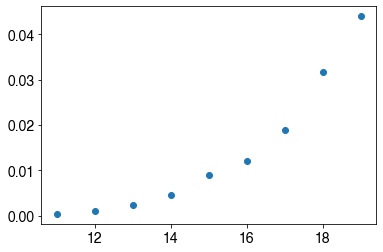

In [44]:
plt.scatter(amp2_p, tw_evap_r2_by_level)

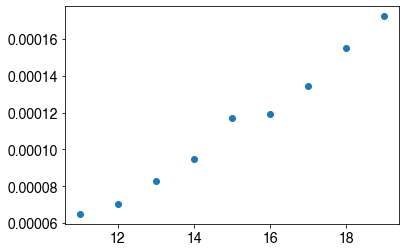

In [47]:
plt.scatter(amp2_p, tw_evap_slope_by_level)

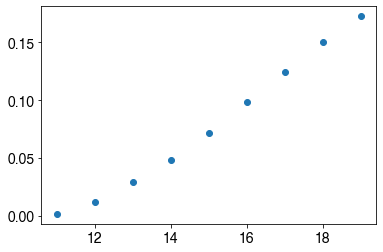

In [45]:
plt.scatter(amp2_p, tx_evap_r2_by_level)

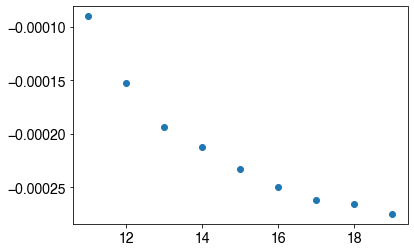

In [46]:
plt.scatter(amp2_p, tx_evap_slope_by_level)

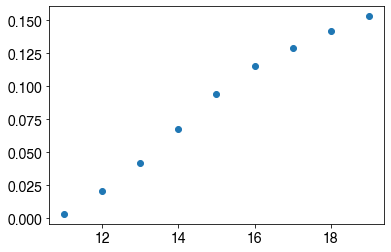

In [34]:
plt.scatter(amp2_p, tx_sm_r2_by_level)

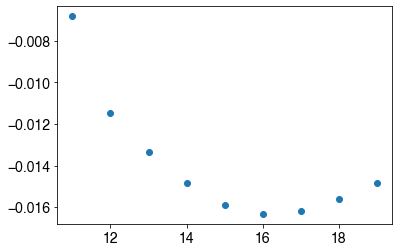

In [35]:
plt.scatter(amp2_p, tx_sm_slope_by_level)

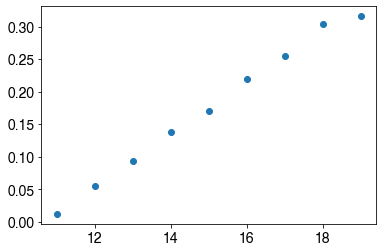

In [36]:
plt.scatter(amp2_p, tw_huss_r2_by_level)

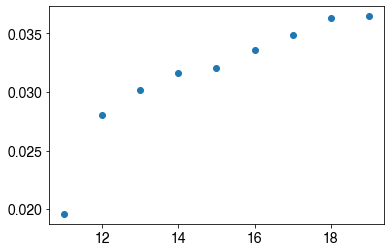

In [37]:
plt.scatter(amp2_p, tw_huss_slope_by_level)

Text(0, 0.5, 'Tx amp')

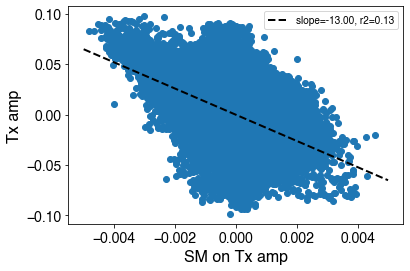

In [38]:
nn = np.where((~np.isnan(tx_amp_1d)) & (~np.isnan(sm_on_tx_amp_1d)))[0]
X = sm.add_constant(sm_on_tx_amp_1d[nn])
mdl = sm.OLS(tx_amp_1d[nn], X).fit()
plt.scatter(sm_on_tx_amp_1d, tx_amp_1d)
x1 = -.005
x2 = .005
plt.plot([x1,x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', lw=2, label='slope=%.2f, r2=%.2f'%(mdl.params[1], mdl.rsquared))
plt.legend()
plt.xlabel('SM on Tx amp')
plt.ylabel('Tx amp')

In [51]:
import pandas as pd

# Assuming var3_amp_1d is your third variable
nn = np.where((~np.isnan(tx_amp_1d)) &  (~np.isnan(sm_on_tx_amp_1d)))[0]

# Create a DataFrame with three columns and name each column
X = pd.DataFrame({
    'sm_on_tx_amp': sm_on_tx_amp_1d[nn],
    'evap_on_tx_amp': evap_on_tx_amp_1d[nn]
})

# Add a constant (intercept term) to the DataFrame
X = sm.add_constant(X)

# Fit the model
mdl = sm.OLS(tx_amp_1d[nn], X).fit()

print(mdl.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                 1.930e+04
Date:                Wed, 21 Jun 2023   Prob (F-statistic):               0.00
Time:                        16:28:09   Log-Likelihood:             4.5634e+05
No. Observations:              181732   AIC:                        -9.127e+05
Df Residuals:                  181729   BIC:                        -9.126e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0013   4.75e-05    -27.

In [25]:
import pandas as pd

# Assuming var3_amp_1d is your third variable
nn = np.where((~np.isnan(tw_amp_1d)) & (~np.isnan(sm_on_tw_amp_1d)) & (~np.isnan(huss_on_tw_amp_1d)) & (~np.isnan(evap_on_tw_amp_1d)))[0]

# Create a DataFrame with three columns and name each column
X = pd.DataFrame({
    'tx_on_tw_amp': tx_on_tw_amp_1d[nn],
#     'sm_on_tw_amp_1d': sm_on_tw_amp_1d[nn],
#     'evap_on_tw_amp_1d': evap_on_tw_amp_1d[nn],
    'huss_on_tw_amp_1d': huss_on_tw_amp_1d[nn]
})

# Add a constant (intercept term) to the DataFrame
X = sm.add_constant(X)

# Fit the model
mdl = sm.OLS(tw_amp_1d[nn], X).fit()

print(mdl.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                 5.164e+04
Date:                Thu, 22 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:32:46   Log-Likelihood:             5.4477e+05
No. Observations:              181732   AIC:                        -1.090e+06
Df Residuals:                  181729   BIC:                        -1.090e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0019   2.88e-0

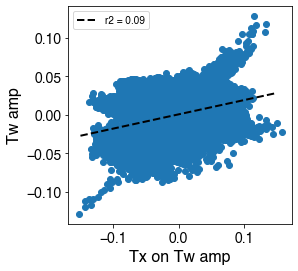

In [376]:
nn = np.where((~np.isnan(tw_amp_1d)) & (~np.isnan(tx_on_tw_amp_1d)))[0]
X = sm.add_constant(tx_on_tw_amp_1d[nn])
mdl = sm.OLS(tw_amp_1d[nn], X).fit()

plt.figure(figsize=(4,4))
plt.scatter(tx_on_tw_amp_1d, tw_amp_1d)
x1 = -.15
x2 = .15
plt.plot([x1,x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', lw=2, label='r2 = %.2f'%mdl.rsquared)
plt.xlabel('Tx on Tw amp')
plt.ylabel('Tw amp')
plt.legend()
# mdl.summary()

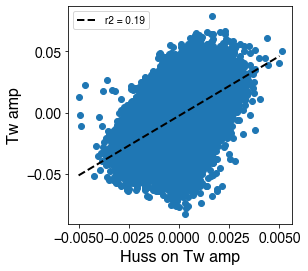

In [41]:
nn = np.where((~np.isnan(tw_amp_1d)) & (~np.isnan(huss_on_tw_amp_1d)))[0]
X = sm.add_constant(huss_on_tw_amp_1d[nn])
mdl = sm.OLS(tw_amp_1d[nn], X).fit()

plt.figure(figsize=(4,4))
plt.scatter(huss_on_tw_amp_1d, tw_amp_1d)
x1 = -.005
x2 = .005
plt.plot([x1,x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', lw=2, label='r2 = %.2f'%mdl.rsquared)
plt.xlabel('Huss on Tw amp')
plt.ylabel('Tw amp')
plt.legend()
# mdl.summary()

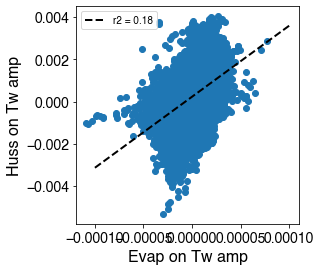

In [406]:
nn = np.where((~np.isnan(huss_on_tw_amp_1d)) & (~np.isnan(evap_on_tw_amp_1d)))[0]
X = sm.add_constant(evap_on_tw_amp_1d[nn])
mdl = sm.OLS(huss_on_tw_amp_1d[nn], X).fit()

plt.figure(figsize=(4,4))
plt.scatter(evap_on_tw_amp_1d, huss_on_tw_amp_1d)
x1 = -.0001
x2 = .0001
plt.plot([x1,x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', lw=2, label='r2 = %.2f'%mdl.rsquared)
plt.xlabel('Evap on Tw amp')
plt.ylabel('Huss on Tw amp')
plt.legend()
# mdl.summary()

Text(0, 0.5, 'TW 99th percentile trend')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


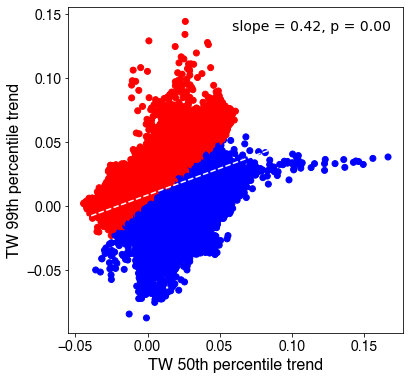

In [26]:
nn = np.where((~np.isnan(tw_100_1d)) & (~np.isnan(tw_50_1d)))[0]
X = sm.add_constant(tw_50_1d[nn])
mdl = sm.OLS(tw_100_1d[nn], X).fit()

font = FontProperties(family='Arial', size=14)

x1 = np.nanmin(tw_50_1d)
x2 = np.nanmax(tw_50_1d)
plt.figure(figsize=(6,6))
plt.scatter(tw_50_1d[nn], tw_100_1d[nn], c=(tw_100_1d[nn]>tw_50_1d[nn]), cmap='bwr')
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--w', label='slope = %.2f, p = %.2f'%(mdl.params[1], mdl.pvalues[1]))
# plt.plot([x1,x2], [0,0], '-k', lw=2)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.xlabel('TW %dth percentile trend'%p2)
plt.ylabel('TW %dth percentile trend'%p1)

Text(0, 0.5, 'Tx 99th percentile trend')

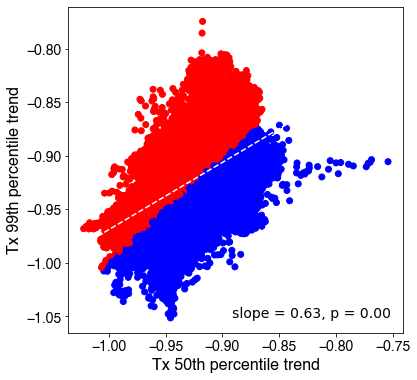

In [105]:
nn = np.where((~np.isnan(tx_100_1d)) & (~np.isnan(tx_50_1d)))[0]
X = sm.add_constant(tx_50_1d[nn])
mdl = sm.OLS(tx_100_1d[nn], X).fit()

font = FontProperties(family='Arial', size=14)

x1 = np.nanmin(tx_50_1d)
x2 = np.nanmax(tx_50_1d)
plt.figure(figsize=(6,6))
plt.scatter(tx_50_1d[nn], tx_100_1d[nn], c=(tx_100_1d[nn]>tx_50_1d[nn]), cmap='bwr')
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--w', label='slope = %.2f, p = %.2f'%(mdl.params[1], mdl.pvalues[1]))
# plt.plot([x1,x2], [0,0], '-k', lw=2)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.xlabel('Tx %dth percentile trend'%p2)
plt.ylabel('Tx %dth percentile trend'%p1)

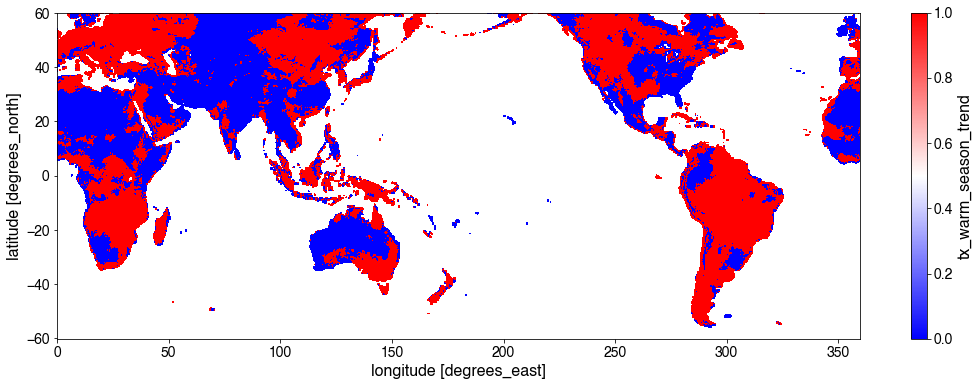

In [403]:
tx_amp_binary = tx_amp>0
tx_amp_land_only = tx_amp_binary.where(land_sea_mask_binary, np.nan)
tx_amp_land_only = tx_amp_land_only.where(~np.isnan(tx_amp), np.nan)
tx_amp_land_only = tx_amp_land_only.sel(latitude=slice(60,-60))
tx_amp_land_only.plot(cmap='bwr', figsize=(18,6))

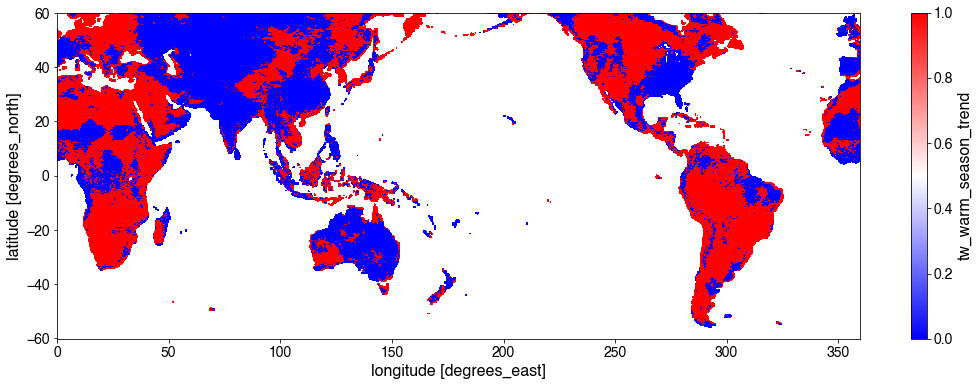

In [86]:
tw_amp_binary = tw_amp>0
tw_amp_land_only = tw_amp_binary.where(land_sea_mask_binary, np.nan)
tw_amp_land_only = tw_amp_land_only.where(~np.isnan(tw_amp), np.nan)
tw_amp_land_only = tw_amp_land_only.sel(latitude=slice(60,-60))
tw_amp_land_only.plot(cmap='bwr', figsize=(18,6))

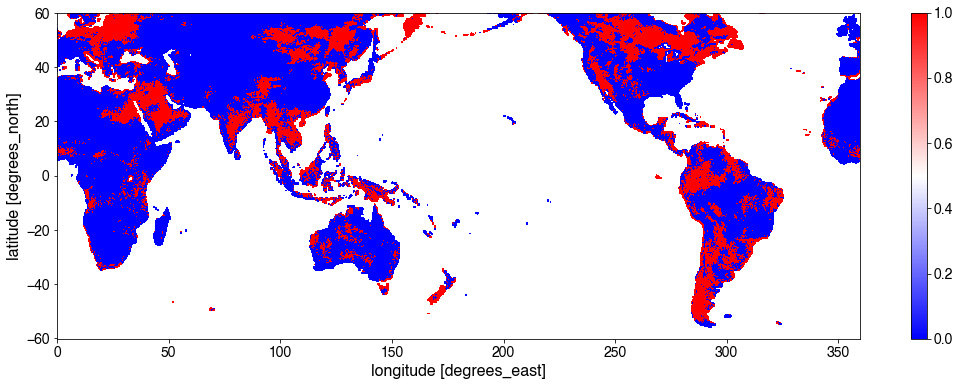

In [298]:
# tx/tw convergence
v1 = tx_on_tw_trend.tx_on_warm_season_tw_trend[-1,:,:] - tx_on_tw_trend.tx_on_warm_season_tw_trend[-10,:,:]
v2 = tw_on_tx_trend.tw_on_warm_season_tx_trend[-1,:,:] - tw_on_tx_trend.tw_on_warm_season_tx_trend[-10,:,:]

tx_amp_binary = xr.where((v1 > 0) & (v2 > 0), 1, 0)
# tx_amp_binary = tx_amp>0 & huss_amp>0
tx_amp_land_only = tx_amp_binary.where(land_sea_mask_binary, np.nan)
tx_amp_land_only = tx_amp_land_only.where(~np.isnan(tx_amp), np.nan)
tx_amp_land_only = tx_amp_land_only.sel(latitude=slice(60,-60))
tx_amp_land_only.plot(cmap='bwr', figsize=(18,6))

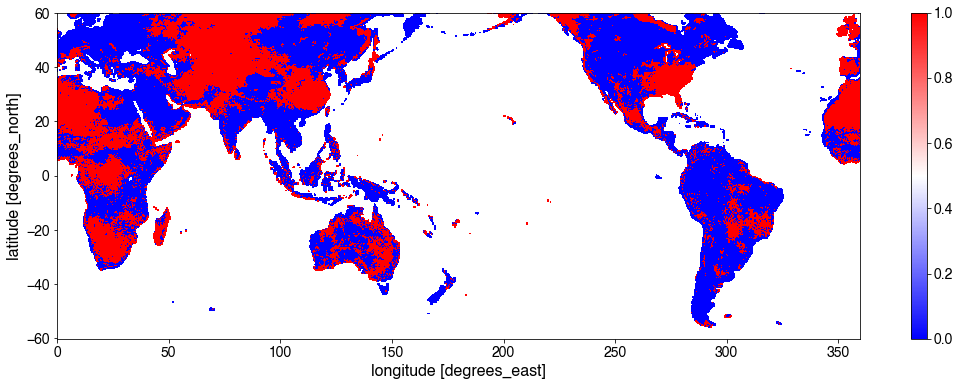

In [297]:
# tx/tw divergence
v1 = tx_on_tw_trend.tx_on_warm_season_tw_trend[-1,:,:] - tx_on_tw_trend.tx_on_warm_season_tw_trend[-10,:,:]
v2 = tw_on_tx_trend.tw_on_warm_season_tx_trend[-1,:,:] - tw_on_tx_trend.tw_on_warm_season_tx_trend[-10,:,:]

tx_amp_binary = xr.where((v1 < 0) & (v2 < 0), 1, 0)
# tx_amp_binary = tx_amp>0 & huss_amp>0
tx_amp_land_only = tx_amp_binary.where(land_sea_mask_binary, np.nan)
tx_amp_land_only = tx_amp_land_only.where(~np.isnan(tx_amp), np.nan)
tx_amp_land_only = tx_amp_land_only.sel(latitude=slice(60,-60))
tx_amp_land_only.plot(cmap='bwr', figsize=(18,6))